In [2]:
% pylab inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load data set
df = pickle.load(open('df.pkl','rb'))
print(df.head())

            date_block_num  shop_id  item_id  item_price  item_cnt_day
date                                                                  
2013-01-01               0       18     5823     2500.00          1.00
2013-01-01               0       46     1830      599.00          3.00
2013-01-01               0       14     1830      599.00          2.00
2013-01-01               0       14     1905      249.00          1.00
2013-01-01               0       14     2808      999.00          2.00


In [72]:
# Transform data into total sale per month of each store-item pair and their average price
aggregation = {'item_price':'mean',
               'item_cnt_day':'sum'}

train_model = df.groupby(['date_block_num','shop_id','item_id']).agg(aggregation)
train_model = train_model.reset_index()
train_model.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,2,1905,249.00,3.00
1,0,2,1916,249.00,3.00
2,0,2,2308,799.00,3.00
3,0,2,2416,449.00,1.00
4,0,2,2808,998.98,17.00


In [73]:
# Sort dataframe
train_model.sort_values(['item_id','shop_id','date_block_num']).head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
7560,10,2,1495,632.33,8.00
8733,11,2,1495,599.00,20.00
9977,12,2,1495,599.00,9.00
12426,14,2,1495,599.00,2.00
13728,15,2,1495,599.00,1.00


In [6]:
# Pivot the table into item sales and item price columns by month
df_pivot = pd.pivot_table(data=pd.DataFrame(train_model),index=['shop_id','item_id'], 
                           columns=['date_block_num'], values=['item_cnt_day','item_price'])
df_pivot = df_pivot.reset_index()

print(df_pivot.head())
print(len(df_pivot))

               shop_id item_id item_cnt_day                                \
date_block_num                            0    1    2    3    4    5    6   
0                    2    1495          nan  nan  nan  nan  nan  nan  nan   
1                    2    1830          nan  nan 3.00 2.00 3.00 2.00 2.00   
2                    2    1855          nan  nan  nan  nan  nan  nan  nan   
3                    2    1905         3.00  nan  nan 2.00  nan 3.00 2.00   
4                    2    1916         3.00 2.00 2.00 2.00 2.00  nan 2.00   

                    ... item_price                                            \
date_block_num    7 ...         24     25     26     27     28     29     30   
0               nan ...        nan    nan    nan 499.00    nan    nan    nan   
1              7.00 ...        nan    nan    nan    nan    nan    nan    nan   
2               nan ...     799.00 627.83 399.50    nan    nan    nan    nan   
3              1.00 ...     249.00 249.00 249.00 249.00 249.

In [7]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919 entries, 0 to 1918
Data columns (total 70 columns):
(shop_id, )           1919 non-null int64
(item_id, )           1919 non-null int64
(item_cnt_day, 0)     459 non-null float64
(item_cnt_day, 1)     534 non-null float64
(item_cnt_day, 2)     659 non-null float64
(item_cnt_day, 3)     654 non-null float64
(item_cnt_day, 4)     711 non-null float64
(item_cnt_day, 5)     772 non-null float64
(item_cnt_day, 6)     802 non-null float64
(item_cnt_day, 7)     866 non-null float64
(item_cnt_day, 8)     1045 non-null float64
(item_cnt_day, 9)     1058 non-null float64
(item_cnt_day, 10)    1173 non-null float64
(item_cnt_day, 11)    1244 non-null float64
(item_cnt_day, 12)    1219 non-null float64
(item_cnt_day, 13)    1230 non-null float64
(item_cnt_day, 14)    1302 non-null float64
(item_cnt_day, 15)    1257 non-null float64
(item_cnt_day, 16)    1291 non-null float64
(item_cnt_day, 17)    1316 non-null float64
(item_cnt_day, 18)    132

In [8]:
# Extract index as a single dataframe
df_index = df_pivot[['shop_id','item_id']]

print(df_index.head())
df_index.info()

               shop_id item_id
date_block_num                
0                    2    1495
1                    2    1830
2                    2    1855
3                    2    1905
4                    2    1916
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1919 entries, 0 to 1918
Data columns (total 2 columns):
(shop_id, )    1919 non-null int64
(item_id, )    1919 non-null int64
dtypes: int64(2)
memory usage: 30.1 KB


In [9]:
# Extract sales columns and fill in nan with zero
df_sales = df_pivot.loc[:,['item_cnt_day']]
df_sales = df_sales.fillna(0)
df_index.columns = df_index.columns.get_level_values(0)
df_sales.columns = df_sales.columns.get_level_values(1)
df_sales = pd.merge(df_index, df_sales, on=df_index.index).drop('key_0', axis=1)
df_sales.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,1495,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,0.00,0.00
1,2,1830,0.00,0.00,3.00,2.00,3.00,2.00,2.00,7.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2,1855,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,2,1905,3.00,0.00,0.00,2.00,0.00,3.00,2.00,1.00,...,5.00,4.00,2.00,2.00,1.00,1.00,1.00,0.00,0.00,0.00
4,2,1916,3.00,2.00,2.00,2.00,2.00,0.00,2.00,3.00,...,0.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00


Unlike sales record where we can simply fill in nan with 0 to replace months of no sales. The price dataframe has nan before and after the months that sales have been records. Therefore, we can use back fill on months before the sales are made and forward fill on the months after. Doing so we can assume that price adjustments are only made on the months that sales are made.

In [81]:
df_price = df_pivot.loc[:,['item_price']]
df_index.columns = df_index.columns.get_level_values(0)
df_price.columns = df_price.columns.get_level_values(1)
df_price = pd.merge(df_index, df_price, on=df_index.index).drop('key_0', axis=1)
df_price.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,1495,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,499.00,nan,nan,nan,499.00,nan,nan
1,2,1830,nan,nan,449.25,599.00,599.00,599.00,399.56,315.57,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2,1855,nan,nan,nan,nan,nan,nan,nan,nan,...,799.00,627.83,399.50,nan,nan,nan,nan,nan,399.00,nan
3,2,1905,249.00,nan,nan,249.00,nan,249.00,249.00,249.00,...,249.00,249.00,249.00,249.00,249.00,249.00,249.00,nan,nan,nan
4,2,1916,249.00,249.00,249.00,249.00,224.00,nan,249.00,249.00,...,nan,249.00,249.00,249.00,249.00,nan,nan,nan,nan,nan


In [82]:
dT_price = df_price.transpose()
df_price = dT_price.fillna(method='bfill').fillna(method='ffill')
df_price = df_price.transpose()
df_price.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2.00,1495.00,632.33,632.33,632.33,632.33,632.33,632.33,632.33,632.33,...,499.00,499.00,499.00,499.00,499.00,499.00,499.00,499.00,499.00,499.00
1,2.00,1830.00,449.25,449.25,449.25,599.00,599.00,599.00,399.56,315.57,...,599.00,599.00,599.00,599.00,599.00,599.00,599.00,599.00,599.00,599.00
2,2.00,1855.00,1199.00,1199.00,1199.00,1199.00,1199.00,1199.00,1199.00,1199.00,...,799.00,627.83,399.50,399.00,399.00,399.00,399.00,399.00,399.00,399.00
3,2.00,1905.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00,...,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00
4,2.00,1916.00,249.00,249.00,249.00,249.00,224.00,249.00,249.00,249.00,...,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00,249.00


In [12]:
# Return the pivoted dataframe back to modeling readable format
melt_sales = df_sales.melt(id_vars=['shop_id','item_id'], var_name='Month', value_name='Sales')
melt_sales['Month'] = melt_sales['Month'].astype(int)

melt_sales.head()

,shop_id,item_id,Month,Sales
0,2,1495,0,0.00
1,2,1830,0,0.00
2,2,1855,0,0.00
3,2,1905,0,3.00
4,2,1916,0,3.00


In [13]:
melt_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65246 entries, 0 to 65245
Data columns (total 4 columns):
shop_id    65246 non-null int64
item_id    65246 non-null int64
Month      65246 non-null int64
Sales      65246 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.0 MB


In [77]:
melt_prices = df_price.melt(id_vars=['shop_id','item_id'], var_name='Month', value_name='Prices')
melt_prices.head()

,shop_id,item_id,Month,Prices
0,2,1495,0,249.00
1,2,1830,0,249.00
2,2,1855,0,249.00
3,2,1905,0,249.00
4,2,1916,0,249.00


In [83]:
melt_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65246 entries, 0 to 65245
Data columns (total 4 columns):
shop_id    65246 non-null int64
item_id    65246 non-null int64
Month      65246 non-null object
Prices     65246 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.0+ MB


In [84]:
melt_prices['shop_id'] = melt_prices['shop_id'].astype(int)
melt_prices['item_id'] = melt_prices['item_id'].astype(int)
melt_prices['Month'] = melt_prices['Month'].astype(int)

melt_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65246 entries, 0 to 65245
Data columns (total 4 columns):
shop_id    65246 non-null int64
item_id    65246 non-null int64
Month      65246 non-null int64
Prices     65246 non-null float64
dtypes: float64(1), int64(3)
memory usage: 2.0 MB


In [85]:
# Join sales and price data into a single dataframe for modeling
melt = melt_sales.join(melt_prices['Prices'], on=melt_sales.index)
melt.head()

,shop_id,item_id,Month,Sales,Prices
0,2,1495,0,0.00,249.00
1,2,1830,0,0.00,249.00
2,2,1855,0,0.00,249.00
3,2,1905,0,3.00,249.00
4,2,1916,0,3.00,249.00


In [18]:
melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65246 entries, 0 to 65245
Data columns (total 5 columns):
shop_id    65246 non-null int64
item_id    65246 non-null int64
Month      65246 non-null int64
Sales      65246 non-null float64
Prices     65246 non-null float64
dtypes: float64(2), int64(3)
memory usage: 2.5 MB


In [19]:
# Create dataframe with features single lagged values
melt2 = melt.copy()

melt2['Last_Month_Sales'] = melt2.groupby(['shop_id','item_id',])['Sales'].shift()
melt2['Last_Month_Diff'] = melt2.groupby(['shop_id','item_id'])['Last_Month_Sales'].diff()

melt2['Price_Diff'] = melt2.groupby(['item_id','shop_id'])['Prices'].diff()
melt2['Last_Month_Prices'] = melt2.groupby(['item_id','shop_id'])['Prices'].shift()
melt2['Last_Month_Price_Diff'] = melt2.groupby(['shop_id','item_id'])['Last_Month_Prices'].diff()

melt2['Price_pct_change'] = melt2['Price_Diff']/melt2['Prices']*100
melt2['Last_Month_Price_pct_change'] = melt2.groupby(['shop_id','item_id'])['Price_pct_change'].shift()

melt2 = melt2.dropna()
melt2

,shop_id,item_id,Month,Sales,Prices,Last_Month_Sales,Last_Month_Diff,Price_Diff,Last_Month_Prices,Last_Month_Price_Diff,Price_pct_change,Last_Month_Price_pct_change
3838,2,1495,2,0.00,449.25,0.00,0.00,200.25,249.00,0.00,44.57,0.00
3839,2,1830,2,3.00,449.25,0.00,0.00,200.25,249.00,0.00,44.57,0.00
3840,2,1855,2,0.00,249.00,0.00,0.00,0.00,249.00,0.00,0.00,0.00
3841,2,1905,2,0.00,249.00,0.00,-3.00,0.00,249.00,0.00,0.00,0.00
3842,2,1916,2,2.00,249.00,2.00,-1.00,0.00,249.00,0.00,0.00,0.00
3843,2,2269,2,0.00,849.00,0.00,0.00,25.00,824.00,25.00,2.94,3.03
3844,2,2308,2,1.00,849.00,4.00,1.00,25.00,824.00,25.00,2.94,3.03
3845,2,2416,2,0.00,1199.00,1.00,0.00,750.00,449.00,0.00,62.55,0.00
3846,2,2445,2,3.00,1199.00,8.00,8.00,0.00,1199.00,200.02,0.00,16.68
3847,2,2753,2,2.00,1199.00,7.00,7.00,0.00,1199.00,200.02,0.00,16.68


In [20]:
# Create dataframe with features twice lagged values
melt3 = melt.copy()

melt3['Last_Month_Sales'] = melt3.groupby(['shop_id','item_id',])['Sales'].shift()
melt3['Last_Month_Diff'] = melt3.groupby(['shop_id','item_id',])['Last_Month_Sales'].diff()
melt3['Last-1_Month_Sales'] = melt3.groupby(['shop_id','item_id',])['Sales'].shift(2)
melt3['Last-1_Month_Diff'] = melt3.groupby(['shop_id','item_id',])['Last-1_Month_Sales'].diff()

melt3['Price_Diff'] = melt3.groupby(['item_id','shop_id'])['Prices'].diff()
melt3['Last_Month_Prices'] = melt3.groupby(['shop_id','item_id',])['Prices'].shift()
melt3['Last-1_Month_Prices'] = melt3.groupby(['shop_id','item_id',])['Prices'].shift(2)

melt3['Last_Month_Price_Diff'] = melt3.groupby(['shop_id','item_id',])['Last_Month_Prices'].diff()
melt3['Last-1_Month_Price_Diff'] = melt3.groupby(['shop_id','item_id',])['Last-1_Month_Prices'].diff()

melt3['Price_pct_change'] = melt3['Price_Diff']/melt3['Prices']*100
melt3['Last_Month_Price_pct_change'] = melt3.groupby(['shop_id','item_id',])['Price_pct_change'].shift()
melt3['Last-1_Month_Price_pct_change'] = melt3.groupby(['shop_id','item_id',])['Price_pct_change'].shift(2)

melt3 = melt3.dropna()
melt3.head()

,shop_id,item_id,Month,Sales,Prices,Last_Month_Sales,Last_Month_Diff,Last-1_Month_Sales,Last-1_Month_Diff,Price_Diff,Last_Month_Prices,Last-1_Month_Prices,Last_Month_Price_Diff,Last-1_Month_Price_Diff,Price_pct_change,Last_Month_Price_pct_change,Last-1_Month_Price_pct_change
5757,2,1495,3,0.00,599.00,0.00,0.00,0.00,0.00,149.75,449.25,249.00,200.25,0.00,25.00,44.57,0.00
5758,2,1830,3,2.00,599.00,3.00,3.00,0.00,0.00,149.75,449.25,249.00,200.25,0.00,25.00,44.57,0.00
5759,2,1855,3,0.00,249.00,0.00,0.00,0.00,0.00,0.00,249.00,249.00,0.00,0.00,0.00,0.00,0.00
5760,2,1905,3,2.00,249.00,0.00,0.00,0.00,-3.00,0.00,249.00,249.00,0.00,0.00,0.00,0.00,0.00
5761,2,1916,3,2.00,249.00,2.00,0.00,2.00,-1.00,0.00,249.00,249.00,0.00,0.00,0.00,0.00,0.00


In [21]:
# Create one more lagged dataframe
melt4 = melt.copy()

melt4['Last_Month_Sales'] = melt4.groupby(['shop_id','item_id',])['Sales'].shift()
melt4['Last-1_Month_Sales'] = melt4.groupby(['shop_id','item_id',])['Sales'].shift(2)
melt4['Last-2_Month_Sales'] = melt4.groupby(['shop_id','item_id',])['Sales'].shift(3)

melt4['Last_Month_Diff'] = melt4.groupby(['shop_id','item_id',])['Last_Month_Sales'].diff()
melt4['Last-1_Month_Diff'] = melt4.groupby(['shop_id','item_id',])['Last-1_Month_Sales'].diff()
melt4['Last-2_Month_Diff'] = melt4.groupby(['shop_id','item_id',])['Last-2_Month_Sales'].diff()

melt4['Price_Diff'] = melt4.groupby(['item_id','shop_id'])['Prices'].diff()
melt4['Last_Month_Prices'] = melt4.groupby(['shop_id','item_id',])['Prices'].shift()
melt4['Last-1_Month_Prices'] = melt4.groupby(['shop_id','item_id',])['Prices'].shift(2)
melt4['Last-2_Month_Prices'] = melt4.groupby(['shop_id','item_id',])['Prices'].shift(3)
melt4['Last_Month_Price_Diff'] = melt4.groupby(['shop_id','item_id',])['Last_Month_Prices'].diff()
melt4['Last-1_Month_Price_Diff'] = melt4.groupby(['shop_id','item_id',])['Last-1_Month_Prices'].diff()
melt4['Last-2_Month_Price_Diff'] = melt4.groupby(['shop_id','item_id',])['Last-2_Month_Prices'].diff()

melt4['Price_pct_change'] = melt4['Price_Diff']/melt4['Prices']*100
melt4['Last_Month_Price_pct_change'] = melt4.groupby(['shop_id','item_id',])['Price_pct_change'].shift()
melt4['Last-1_Month_Price_pct_change'] = melt4.groupby(['shop_id','item_id',])['Price_pct_change'].shift(2)
melt4['Last-2_Month_Price_pct_change'] = melt4.groupby(['shop_id','item_id',])['Price_pct_change'].shift(3)

melt4 = melt4.dropna()
melt4.head()

,shop_id,item_id,Month,Sales,Prices,Last_Month_Sales,Last-1_Month_Sales,Last-2_Month_Sales,Last_Month_Diff,Last-1_Month_Diff,...,Last_Month_Prices,Last-1_Month_Prices,Last-2_Month_Prices,Last_Month_Price_Diff,Last-1_Month_Price_Diff,Last-2_Month_Price_Diff,Price_pct_change,Last_Month_Price_pct_change,Last-1_Month_Price_pct_change,Last-2_Month_Price_pct_change
7676,2,1495,4,0.00,599.00,0.00,0.00,0.00,0.00,0.00,...,599.00,449.25,249.00,149.75,200.25,0.00,0.00,25.00,44.57,0.00
7677,2,1830,4,3.00,599.00,2.00,3.00,0.00,-1.00,3.00,...,599.00,449.25,249.00,149.75,200.25,0.00,0.00,25.00,44.57,0.00
7678,2,1855,4,0.00,224.00,0.00,0.00,0.00,0.00,0.00,...,249.00,249.00,249.00,0.00,0.00,0.00,-11.16,0.00,0.00,0.00
7679,2,1905,4,0.00,224.00,2.00,0.00,0.00,2.00,0.00,...,249.00,249.00,249.00,0.00,0.00,0.00,-11.16,0.00,0.00,0.00
7680,2,1916,4,2.00,224.00,2.00,2.00,2.00,0.00,0.00,...,249.00,249.00,249.00,0.00,0.00,0.00,-11.16,0.00,0.00,0.00


In [22]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score

def rms(y_test, y_pred):
    return sqrt(mean_squared_error(y_test, y_pred))

def rmsle(y_test, y_pred):
    return sqrt(mean_squared_log_error(y_test, y_pred))

def r2(y_test, y_pred):
    return r2_score(y_test, y_pred)

### Create baseline model for comparison

In [23]:
mean_rms = []
mean_absolute_error = []
r2s = []

for month in arange(31,33):
    start = time.time()
    train = melt2[melt2['Month'] < month]
    test = melt2[melt2['Month'] == month]
    
    p = test['Sales'].values
    val = test['Last_Month_Sales'].values
    
    error = rms(val, p)
    abs_error = mean(abs(val - p))
    error_r2 = r2(val, p)
    #percent_error = (abs_error / yts).mean()    
    
    print('Month %s - RMS %.3f \t Absolute Error %.3f \t R2 %.2f' % (month, error, abs_error, error_r2))

    mean_rms.append(error)
    mean_absolute_error.append(abs_error)
    r2s.append(error_r2)
    
    #do some stuff
    stop = time.time()
    duration = stop-start
    #print('Process time %.2f' % duration)
    
print('Mean Error = %.3f' % np.mean(mean_rms))            
print('Mean Absolute Error = %.3f' % np.mean(mean_absolute_error))
print('Median R2 Score = %.3f' % np.median(r2s))
print('Mean R2 Score = %.3f' % np.mean(r2s))

Month 31 - RMS 6.885 	 Absolute Error 2.388 	 R2 0.88
Month 32 - RMS 7.839 	 Absolute Error 2.440 	 R2 0.84
Mean Error = 7.362
Mean Absolute Error = 2.414
Median R2 Score = 0.859
Mean R2 Score = 0.859


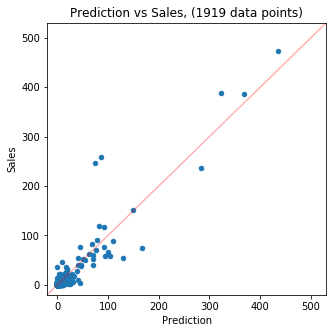

In [24]:
test.loc[:, 'Prediction'] = np.round(val)
test.plot.scatter(x='Prediction', y='Sales', figsize=(5,5), title=('Prediction vs Sales, (%i data points)' % len(test)))
plt.xlim(-20,530)
plt.ylim(-20,530)
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()

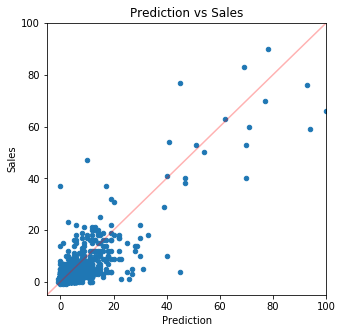

In [25]:
test.loc[:, 'Prediction'] = np.round(val)
test.plot.scatter(x='Prediction', y='Sales', figsize=(5,5), title=('Prediction vs Sales'))
plt.xlim(-5,100)
plt.ylim(-5,100)
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()

We used last month data as baseline model for evaluating our regressor models. The R2 values of forecasting of the baseline model is already fairly high for both August and September. This means that the sales is consistent throughout the last few months.

## Use Random Forest Regressor For Forecasting

In [26]:
%%time
mean_rms = []
mean_absolute_error = []
r2s = []

for month in arange(31,33):
    start = time.time()
    train = melt2[melt2['Month'] < month]
    test = melt2[melt2['Month'] == month]
    
    xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, test['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    p = mdl.predict(xts)
    
    abs_error = mean(abs(yts - p))
    error_r2 = r2(yts, p)
    #percent_error = (abs_error / yts).mean()    
    error = rms(yts, p)
    print('Month %s - RMS %.3f \t Absolute Error %.3f \t R2 %.2f' % (month, error, abs_error, error_r2))

    mean_absolute_error.append(abs_error)
    mean_rms.append(error)
    r2s.append(error_r2)
    
    #do some stuff
    stop = time.time()
    duration = stop-start
    #print('Process time %.2f' % duration)
    
print('Mean Error = %.3f' % np.mean(mean_rms))        
print('Mean Absolute Error = %.3f' % np.mean(mean_absolute_error))
print('Median R2 Score = %.3f' % np.median(r2s))
print('Mean R2 Score = %.3f' % np.mean(r2s))

Month 31 - RMS 7.615 	 Absolute Error 2.518 	 R2 0.85
Month 32 - RMS 7.211 	 Absolute Error 2.170 	 R2 0.88
Mean Error = 7.413
Mean Absolute Error = 2.344
Median R2 Score = 0.864
Mean R2 Score = 0.864
CPU times: user 3min 11s, sys: 1.66 s, total: 3min 12s
Wall time: 55.3 s


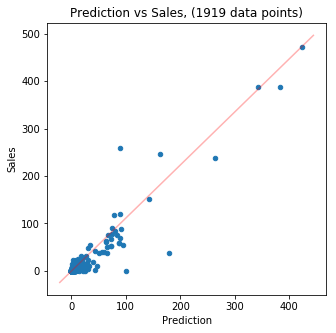

In [27]:
test.loc[:, 'Prediction'] = np.round(p)
test.plot.scatter(x='Prediction', y='Sales', figsize=(5,5), title=('Prediction vs Sales, (%i data points)' % len(test)))
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()

In [28]:
%%time
mean_rms = []
mean_absolute_error = []
r2s = []

for month in arange(31,33):
    start = time.time()
    train = melt3[melt3['Month'] < month]
    test = melt3[melt3['Month'] == month]
    
    xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, test['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    p = mdl.predict(xts)
    
    abs_error = mean(abs(yts - p))
    error_r2 = r2(yts, p)
    #percent_error = (abs_error / yts).mean()    
    error = rms(yts, p)
    print('Month %s - RMS %.3f \t Absolute Error %.3f \t R2 %.2f' % (month, error, abs_error, error_r2))

    mean_absolute_error.append(abs_error)
    mean_rms.append(error)
    r2s.append(error_r2)
    
    #do some stuff
    stop = time.time()
    duration = stop-start
    #print('Process time %.2f' % duration)
    
print('Mean Error = %.3f' % np.mean(mean_rms))        
print('Mean Absolute Error = %.3f' % np.mean(mean_absolute_error))
print('Median R2 Score = %.3f' % np.median(r2s))
print('Mean R2 Score = %.3f' % np.mean(r2s))

Month 31 - RMS 9.314 	 Absolute Error 2.732 	 R2 0.77
Month 32 - RMS 6.993 	 Absolute Error 2.226 	 R2 0.89
Mean Error = 8.153
Mean Absolute Error = 2.479
Median R2 Score = 0.830
Mean R2 Score = 0.830
CPU times: user 4min 39s, sys: 2.37 s, total: 4min 42s
Wall time: 1min 35s


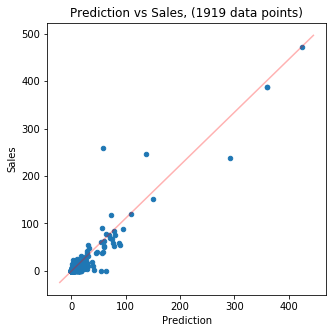

In [29]:
test.loc[:, 'Prediction'] = np.round(p)
test.plot.scatter(x='Prediction', y='Sales', figsize=(5,5), title=('Prediction vs Sales, (%i data points)' % len(test)))
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()

In [30]:
%%time
mean_rms = []
mean_absolute_error = []
r2s = []

for month in arange(31,33):
    start = time.time()
    train = melt4[melt4['Month'] < month]
    test = melt4[melt4['Month'] == month]
    
    xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, test['Sales'].values
    
    mdl = RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    p = mdl.predict(xts)
    
    abs_error = mean(abs(yts - p))
    error_r2 = r2(yts, p)
    #percent_error = (abs_error / yts).mean()    
    error = rms(yts, p)
    print('Month %s - RMS %.3f \t Absolute Error %.3f \t R2 %.2f' % (month, error, abs_error, error_r2))

    mean_absolute_error.append(abs_error)
    mean_rms.append(error)
    r2s.append(error_r2)
    
    #do some stuff
    stop = time.time()
    duration = stop-start
    #print('Process time %.2f' % duration)
    
print('Mean Error = %.3f' % np.mean(mean_rms))        
print('Mean Absolute Error = %.3f' % np.mean(mean_absolute_error))
print('Median R2 Score = %.3f' % np.median(r2s))
print('Mean R2 Score = %.3f' % np.mean(r2s))

Month 31 - RMS 8.351 	 Absolute Error 2.776 	 R2 0.81
Month 32 - RMS 6.894 	 Absolute Error 2.303 	 R2 0.89
Mean Error = 7.623
Mean Absolute Error = 2.540
Median R2 Score = 0.854
Mean R2 Score = 0.854
CPU times: user 6min 40s, sys: 3.51 s, total: 6min 44s
Wall time: 2min 2s


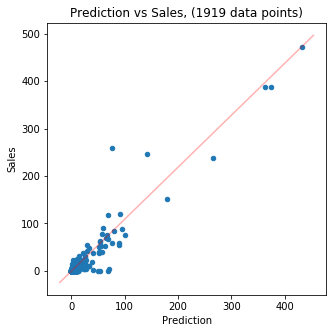

In [31]:
test.loc[:, 'Prediction'] = np.round(p)
test.plot.scatter(x='Prediction', y='Sales', figsize=(5,5), title=('Prediction vs Sales, (%i data points)' % len(test)))
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()

The random forest models show some improvement from the baseline model by single digits in R2 value. Basic feature engineering helped optimize forecasting up to a point. In this case, the performance peaked at three lags and difference of last month's data. The best model that yields the highest R2 score is using sales data of either two or three previous months.

Next, we will optimize the model by choosing the most efficient number of estimator.

In [32]:
%%time
train = melt3[melt3['Month'] < 32]
test = melt3[melt3['Month'] == 32]

xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
ytr, yts = train['Sales'].values, test['Sales'].values

R2Score = []
CompTime = []

for trees in [10, 20, 50, 100, 200, 400, 600, 800, 1000]:
    t0 = time.process_time()
    RFR_time = RandomForestRegressor(n_estimators=trees, n_jobs=-1, random_state=0)
    RFR_time.fit(xtr, ytr)
    p = RFR_time.predict(xts)

    abs_error = mean(abs(yts - p))
    error_r2 = r2(yts, p)
    R2Score.append(error_r2)
    print(trees)
    print("Elapsed time: %.3f, error: %.3f" %(time.process_time() - t0, error_r2))
    CompTime.append((time.process_time() - t0)/60)

10
Elapsed time: 6.742, error: 0.847
20
Elapsed time: 14.804, error: 0.864
50
Elapsed time: 35.510, error: 0.886
100
Elapsed time: 74.126, error: 0.887
200
Elapsed time: 144.288, error: 0.889
400
Elapsed time: 283.660, error: 0.893
600
Elapsed time: 432.799, error: 0.894
800
Elapsed time: 565.511, error: 0.895
1000
Elapsed time: 700.411, error: 0.896
CPU times: user 37min 23s, sys: 14.1 s, total: 37min 37s
Wall time: 17min 25s


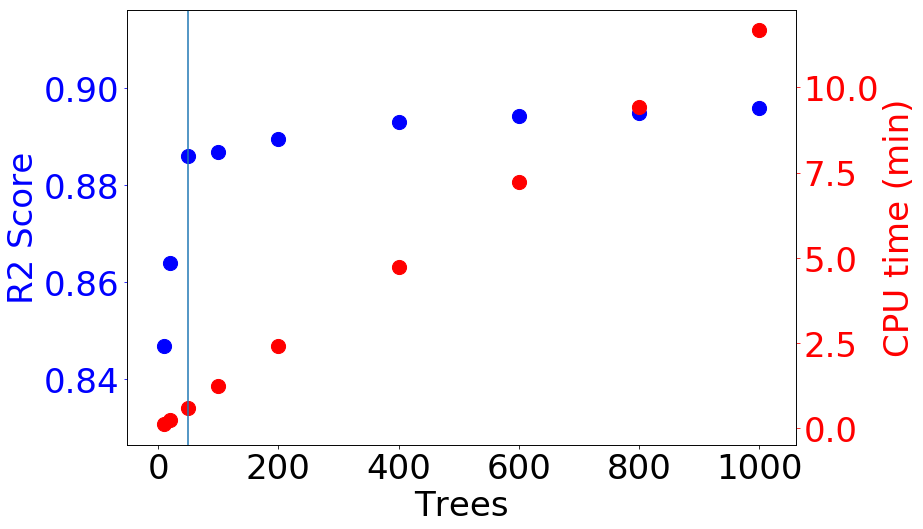

In [33]:
from collections import OrderedDict
df_rf = pd.DataFrame(OrderedDict({"Trees": [10, 20, 50, 100, 200, 400, 600, 800, 1000],
                     "R2 Score": R2Score, "CPU Time": CompTime}))
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.scatter(df_rf.Trees, df_rf["R2 Score"], color='b', s=200)
ax1.set_ylabel("R2 Score", size=34, color='b')
plt.xticks(fontsize=34)
plt.xlabel("Trees", size=34)
ax1.tick_params('y', colors='b', labelsize=34)

ax2 = ax1.twinx()
ax2.scatter(df_rf.Trees, df_rf["CPU Time"], color='r', s=200)
ax2.set_ylabel("CPU time (min)", size=34, color='r')
ax2.tick_params('y', colors='r', labelsize = 34)

plt.axvline(50)

The chart above shows R2 value plateaued at 50 trees. We will go ahead and use 50 trees for the model.

Next, let's optimize the model by looking at feature importances.

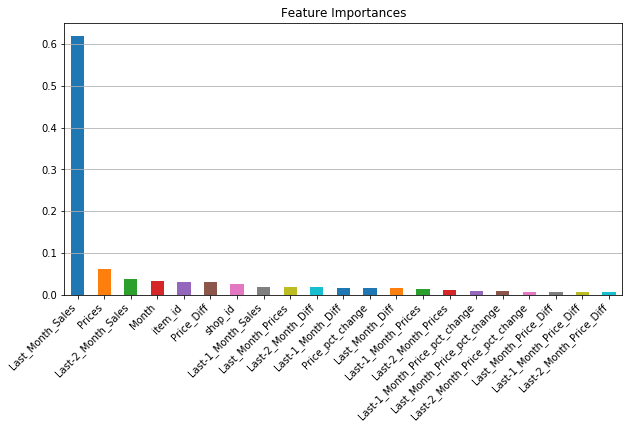

In [34]:
predictors = [x for x in melt4.columns if x not in 'Sales']
plt.subplots(figsize=(10,5))
coef = pd.Series(mdl.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances')
plt.xticks(rotation=45,horizontalalignment='right')
plt.grid(True, axis='y')

Interestingly, the feature of last month's sale is the only feature that has significant importance. And the majority of the features are below 0.05 or less. This makes sense because the baseline model that uses last month's sale record has R2 value of 0.84 on predicting September's sales.

Let's keep only the top 10 features and drop the bottom 11 to try again.

In [35]:
melt4.columns

Index(['shop_id', 'item_id', 'Month', 'Sales', 'Prices', 'Last_Month_Sales',
       'Last-1_Month_Sales', 'Last-2_Month_Sales', 'Last_Month_Diff',
       'Last-1_Month_Diff', 'Last-2_Month_Diff', 'Price_Diff',
       'Last_Month_Prices', 'Last-1_Month_Prices', 'Last-2_Month_Prices',
       'Last_Month_Price_Diff', 'Last-1_Month_Price_Diff',
       'Last-2_Month_Price_Diff', 'Price_pct_change',
       'Last_Month_Price_pct_change', 'Last-1_Month_Price_pct_change',
       'Last-2_Month_Price_pct_change'],
      dtype='object')

In [43]:
melt_trimmed = melt4.drop(['Last-2_Month_Price_Diff','Last-1_Month_Price_Diff','Last_Month_Price_Diff',
                           'Last-2_Month_Price_pct_change','Last-1_Month_Price_pct_change','Last_Month_Price_pct_change',
                           'Last-2_Month_Prices','Last-1_Month_Prices','Last_Month_Diff',
                           'Price_pct_change','Last-1_Month_Diff'
                          ], axis=1)

In [37]:
def Regressor_modeling(model, data):
    for month in arange(31,33):
        start = time.time()
        train = data[data['Month'] < month]
        test = data[data['Month'] == month]

        xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
        ytr, yts = train['Sales'].values, test['Sales'].values

        mdl = model
        mdl.fit(xtr, ytr)
        p = mdl.predict(xts)

        abs_error = mean(abs(yts - p))
        error_r2 = r2(yts, p)
        error = rms(yts, p)
        print('Month %s - RMS %.3f \t Absolute Error %.3f \t R2 %.2f' % (month, error, abs_error, error_r2))

In [44]:
%%time
mdl_RF = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=0)

Regressor_modeling(mdl_RF, melt_trimmed)

Month 31 - RMS 7.982 	 Absolute Error 2.522 	 R2 0.83
Month 32 - RMS 6.865 	 Absolute Error 2.145 	 R2 0.89
CPU times: user 35 s, sys: 380 ms, total: 35.3 s
Wall time: 10 s


In [45]:
train = melt_trimmed[melt_trimmed['Month'] < 32]
test = melt_trimmed[melt_trimmed['Month'] == 32]

xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
ytr, yts = train['Sales'].values, test['Sales'].values

mdl_RF.fit(xtr, ytr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

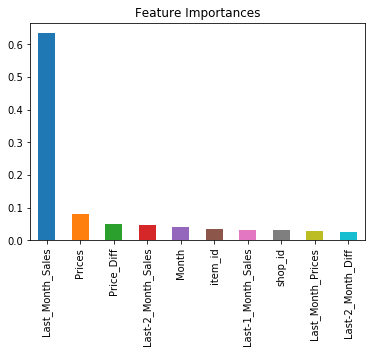

In [71]:
predictors = [x for x in melt_trimmed.columns if x not in 'Sales']
coef = pd.Series(mdl_RF.feature_importances_, predictors).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances')

Removing features with little importance has made no difference in performance. Now saving model for model comparison.

In [65]:
pickle.dump(mdl_RF, open('RFR_final.pkl','wb'))

## Use Gradient Boosting For Forecasting

In [47]:
%%time
mean_rms = []
mean_absolute_error = []
r2s = []

for month in arange(31,33):
    start = time.time()
    train = melt2[melt2['Month'] < month]
    test = melt2[melt2['Month'] == month]
    
    xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, test['Sales'].values
    
    mdl = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, random_state=0)
    mdl.fit(xtr, ytr)
    p = mdl.predict(xts)
    
    abs_error = mean(abs(yts - p))
    error_r2 = r2(yts, p)
    #percent_error = (abs_error / yts).mean()    
    error = rms(yts, p)
    print('Month %s - RMS %.3f \t Absolute Error %.3f \t R2 %.2f' % (month, error, abs_error, error_r2))

    mean_absolute_error.append(abs_error)
    mean_rms.append(error)
    r2s.append(error_r2)
    
    #do some stuff
    stop = time.time()
    duration = stop-start
    #print('Process time %.2f' % duration)
    
print('Mean Error = %.3f' % np.mean(mean_rms))        
print('Mean Absolute Error = %.3f' % np.mean(mean_absolute_error))
print('Median R2 Score = %.3f' % np.median(r2s))
print('Mean R2 Score = %.3f' % np.mean(r2s))

Month 31 - RMS 6.809 	 Absolute Error 3.007 	 R2 0.88
Month 32 - RMS 6.950 	 Absolute Error 2.373 	 R2 0.89
Mean Error = 6.880
Mean Absolute Error = 2.690
Median R2 Score = 0.884
Mean R2 Score = 0.884
CPU times: user 25.4 s, sys: 198 ms, total: 25.6 s
Wall time: 25.9 s


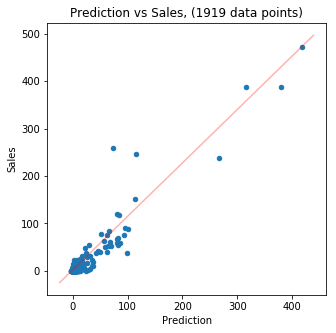

In [48]:
test.loc[:, 'Prediction'] = np.round(p)
test.plot.scatter(x='Prediction', y='Sales', figsize=(5,5), title=('Prediction vs Sales, (%i data points)' % len(test)))
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()

In [49]:
%%time
mean_rms = []
mean_absolute_error = []
r2s = []

for month in arange(31,33):
    start = time.time()
    train = melt3[melt3['Month'] < month]
    test = melt3[melt3['Month'] == month]
    
    xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, test['Sales'].values
    
    mdl = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, random_state=0)
    mdl.fit(xtr, ytr)
    p = mdl.predict(xts)
    
    abs_error = mean(abs(yts - p))
    error_r2 = r2(yts, p)
    #percent_error = (abs_error / yts).mean()    
    error = rms(yts, p)
    print('Month %s - RMS %.3f \t Absolute Error %.3f \t R2 %.2f' % (month, error, abs_error, error_r2))

    mean_absolute_error.append(abs_error)
    mean_rms.append(error)
    r2s.append(error_r2)
    
    #do some stuff
    stop = time.time()
    duration = stop-start
    #print('Process time %.2f' % duration)
    
print('Mean Error = %.3f' % np.mean(mean_rms))        
print('Mean Absolute Error = %.3f' % np.mean(mean_absolute_error))
print('Median R2 Score = %.3f' % np.median(r2s))
print('Mean R2 Score = %.3f' % np.mean(r2s))

Month 31 - RMS 7.309 	 Absolute Error 3.054 	 R2 0.86
Month 32 - RMS 7.079 	 Absolute Error 2.462 	 R2 0.89
Mean Error = 7.194
Mean Absolute Error = 2.758
Median R2 Score = 0.872
Mean R2 Score = 0.872
CPU times: user 32.3 s, sys: 112 ms, total: 32.4 s
Wall time: 32.5 s


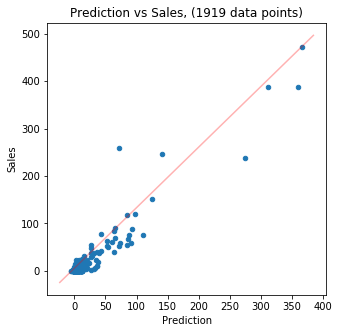

In [50]:
test.loc[:, 'Prediction'] = np.round(p)
test.plot.scatter(x='Prediction', y='Sales', figsize=(5,5), title=('Prediction vs Sales, (%i data points)' % len(test)))
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()

In [52]:
%%time
mean_rms = []
mean_absolute_error = []
r2s = []

for month in arange(31,33):
    start = time.time()
    train = melt4[melt4['Month'] < month]
    test = melt4[melt4['Month'] == month]
    
    xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
    ytr, yts = train['Sales'].values, test['Sales'].values
    
    mdl = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, random_state=0)
    mdl.fit(xtr, ytr)
    p = mdl.predict(xts)
    
    abs_error = mean(abs(yts - p))
    error_r2 = r2(yts, p)
    #percent_error = (abs_error / yts).mean()    
    error = rms(yts, p)
    print('Month %s - RMS %.3f \t Absolute Error %.3f \t R2 %.2f' % (month, error, abs_error, error_r2))

    mean_absolute_error.append(abs_error)
    mean_rms.append(error)
    r2s.append(error_r2)
    
print('Mean Error = %.3f' % np.mean(mean_rms))        
print('Mean Absolute Error = %.3f' % np.mean(mean_absolute_error))
print('Median R2 Score = %.3f' % np.median(r2s))
print('Mean R2 Score = %.3f' % np.mean(r2s))

Month 31 - RMS 8.285 	 Absolute Error 3.089 	 R2 0.82
Month 32 - RMS 7.311 	 Absolute Error 2.637 	 R2 0.88
Mean Error = 7.798
Mean Absolute Error = 2.863
Median R2 Score = 0.848
Mean R2 Score = 0.848
CPU times: user 41.1 s, sys: 132 ms, total: 41.2 s
Wall time: 41.3 s


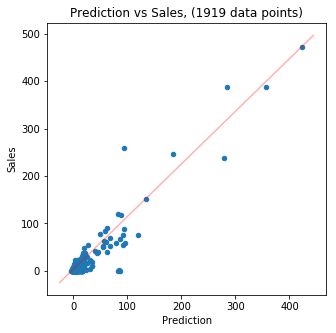

In [53]:
test.loc[:, 'Prediction'] = np.round(p)
test.plot.scatter(x='Prediction', y='Sales', figsize=(5,5), title=('Prediction vs Sales, (%i data points)' % len(test)))
plt.plot(xlim(), ylim(), ls="-", c='r', alpha=.3)
plt.show()

The training time of gradient boosting is much quicker compared to random forest. And the performance of gradient boosting model peaked at first and second lag of monthly data. The performance between the two regressors are similar. We will also optimize gradient boosting model and compare their performances with hold out set.

### Tuning Gradient Boosting estimators

In [54]:
%%time
train = melt3[melt3['Month'] < 32]
test = melt3[melt3['Month'] == 32]

xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
ytr, yts = train['Sales'].values, test['Sales'].values

R2Score_GBR = []
CompTime_GBR = []

for trees in [10, 20, 50, 100, 200, 400, 600, 800, 1000]:
    t0 = time.process_time()
    GBR_time = GradientBoostingRegressor(n_estimators=trees, random_state=0)
    GBR_time.fit(xtr, ytr)
    p = GBR_time.predict(xts)

    abs_error = mean(abs(yts - p))
    error_r2 = r2(yts, p)
    R2Score_GBR.append(error_r2)
    print(trees)
    print("Elapsed time: %.3f, error: %.3f" %(time.process_time() - t0, error_r2))
    CompTime_GBR.append((time.process_time() - t0)/60)

10
Elapsed time: 0.430, error: 0.699
20
Elapsed time: 0.816, error: 0.809
50
Elapsed time: 1.614, error: 0.838
100
Elapsed time: 3.197, error: 0.855
200
Elapsed time: 6.141, error: 0.869
400
Elapsed time: 11.997, error: 0.886
600
Elapsed time: 22.418, error: 0.890
800
Elapsed time: 29.194, error: 0.893
1000
Elapsed time: 30.440, error: 0.894
CPU times: user 1min 45s, sys: 561 ms, total: 1min 46s
Wall time: 1min 47s


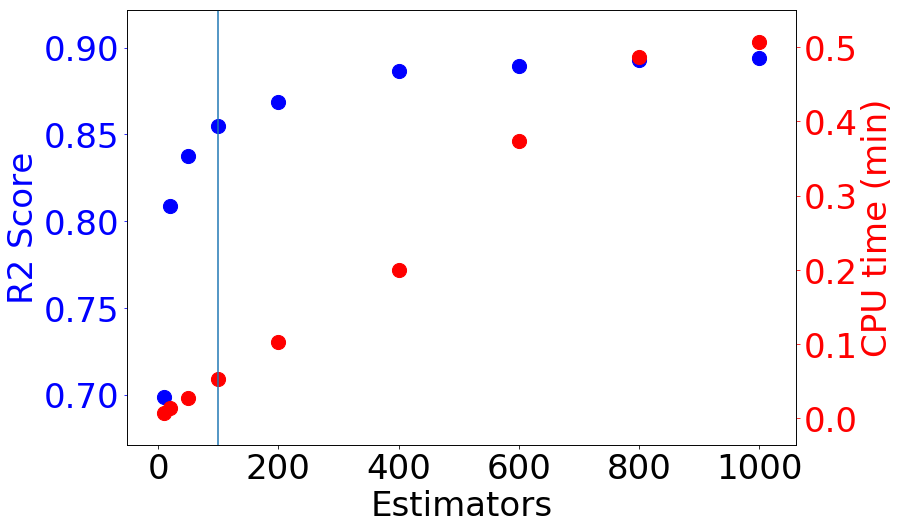

In [56]:
from collections import OrderedDict
df_gb = pd.DataFrame(OrderedDict({"Estimators": [10, 20, 50, 100, 200, 400, 600, 800, 1000],
                     "R2 Score": R2Score_GBR, "CPU Time": CompTime_GBR}))
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.scatter(df_gb.Estimators, df_gb["R2 Score"], color='b', s=200)
ax1.set_ylabel("R2 Score", size=34, color='b')
plt.xticks(fontsize=34)
plt.xlabel("Estimators", size=34)
ax1.tick_params('y', colors='b', labelsize=34)

ax2 = ax1.twinx()
ax2.scatter(df_gb.Estimators, df_gb["CPU Time"], color='r', s=200)
ax2.set_ylabel("CPU time (min)", size=34, color='r')
ax2.tick_params('y', colors='r', labelsize = 34)

plt.axvline(100)

The performance seems to plateau when estimator reaches 100 or above. We will use 100 estimators to compare with other models.

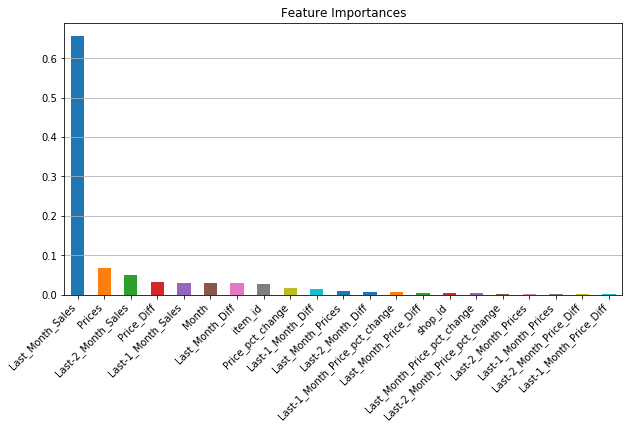

In [70]:
predictors_GB = [x for x in melt4.columns if x not in 'Sales']
plt.subplots(figsize=(10,5))
coef = pd.Series(mdl.feature_importances_, predictors_GB).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances')
plt.xticks(rotation=45,horizontalalignment='right')
plt.grid(True, axis='y')

Similarly to random forest regressor, sale of last month is weighted much more than the rest of features. Likewise, we will keep the top 10 features and try to fit the model again.

In [60]:
melt_GB_trimmed = melt4.drop(['Last-2_Month_Price_Diff','Last-1_Month_Price_Diff','Last_Month_Price_Diff',
                              'Last-2_Month_Prices','Last-1_Month_Prices','Last_Month_Prices',
                              'Last-2_Month_Price_pct_change','Last-1_Month_Price_pct_change','Last_Month_Price_pct_change',
                              'shop_id','Last-2_Month_Diff'
                             ], axis=1)

In [61]:
%%time
mdl_GBR = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=0)

Regressor_modeling(mdl_GBR, melt_GB_trimmed)

Month 31 - RMS 7.371 	 Absolute Error 2.961 	 R2 0.86
Month 32 - RMS 7.242 	 Absolute Error 2.640 	 R2 0.88
CPU times: user 4.22 s, sys: 48.1 ms, total: 4.26 s
Wall time: 4.32 s


In [63]:
train = melt_GB_trimmed[melt_GB_trimmed['Month'] < 32]
test = melt_GB_trimmed[melt_GB_trimmed['Month'] == 32]

xtr, xts = train.drop(['Sales'], axis=1), test.drop(['Sales'], axis=1)
ytr, yts = train['Sales'].values, test['Sales'].values

mdl_GBR.fit(xtr, ytr)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

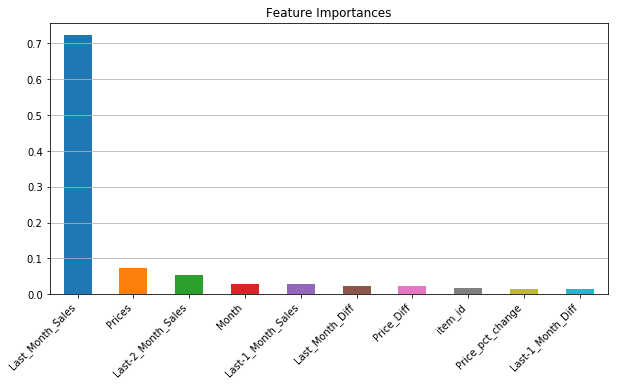

In [69]:
predictors_GB = [x for x in melt_GB_trimmed.columns if x not in 'Sales']

plt.subplots(figsize=(10,5))
coef = pd.Series(mdl_GBR.feature_importances_, predictors_GB).sort_values(ascending=False)
coef.plot(kind='bar', title='Feature Importances')
plt.xticks(rotation=45,horizontalalignment='right')
plt.grid(True, axis='y')

Dropping weak features has little or no effect on the performance of gradient boosting regressor. The importance of last month's sale has increased as bottom features have been dropped. Let's save the model for comparison.

In [67]:
pickle.dump(mdl_GBR, open('GBR_final.pkl','wb'))